 Q-обучение игра в игру 'Taxi-v3'

В данном задании требуется работать с библиотекой Gym, которую не проходили в рамках этой лекции. На следующем занятии *Политические методы обучения, алгоритм REINFORCE* будет рассматриваться синтаксис этой библиотеки, но вы также можете найти синтаксис в документации и в шаблонных кодах, которые выложили в интернет.

В этом задании требуется реализовать классический алгоритм Q-обучения на среде 'Taxi-v3' - т.е. нельзя использовать нейронные сети, нужно использовать Q-таблицу. В данной среде всего 500 уникальных состояний, так что Q-таблица будет работать лучше и обучаться намного быстрее, чем нейронная сеть. 

Нужную документацию можно найти по следующей ссылке: https://gym.openai.com/envs/Taxi-v3/

Импортируем библиотеку gym.

In [ ]:
import gym         #Импортируем библиотеку gym (встроенная в колаб)
import numpy as np #Импортируем numpy
from tensorflow.keras.models import Sequential, load_model #Импортируем функцию для создания модели и загрузки модели
from tensorflow.keras.layers import * #Импортируем все слои кераса
from tensorflow.keras.optimizers import RMSprop #Импортируем оптимизатор RMSprop
import tensorflow as tf                    #Импортируем тензорфлоу
import matplotlib.pyplot as plt            #Импортируем pyplot для визуализации данных
import pickle                              #Импортируем модуль pickle для сохранения и загрузки данных
import random                              #Импортируем модуль для генерации рандомных чисел
from moviepy.editor import *               #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
import cv2                                 #Импортируем библиотеку cv2 (используется для воспроизведение видео)
from google.colab import output            #Импортируем функцию для управления вывода в колаб-ячейках
from IPython.display import clear_output
import time

#Импортируем тип данных deque из встроенного модуля питона
from collections import deque   #deque - это список где автоматический удаляются старые значения при добовлении новых, чтобы не было переполнение памяти.

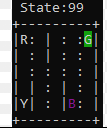

Мы будем взаимодействовать со средой, которая называется `taxi-v3`. Агент управляет такси, которая должна забирать пассажиров и доставлять их в указанные точки. Агент имеет 6 действий (забирать, доставлять, двигаться влево, двигаться вправо, двигаться вверх, двигаться вниз).

За неправильные действия (не взял пассажира, не туда сбросил пассажира, слишком долго вёз пассажира) назначаются отрициательные наргады. За своевременную доставку пассажира в нужное назначение даются положительные награды. По этому, цель алгоритма - обучиться правильно забирать и доставлять пассажиров.

In [ ]:
env = gym.make('Taxi-v3')          #Создаем игровую среду через библиотеку gym
state = env.reset()                #Начинаем новый эпизод, извлекаем состояние
print("Пример состояния:", state)  #Отображаем пример состояние (будет скалярное число)
print("Пространство действий:", env.action_space) #Смотрим на размер пространства действий

Пример состояния: 403
Пространство действий: Discrete(6)


In [ ]:
#Ваш код

Тест работы среды

In [ ]:

print(env.action_space)
print(env.observation_space)
print(env.reward_range)
print(env.class_name)
print(env.metadata)
print(env.close)
print(env.unwrapped)

Discrete(6)
Discrete(500)
(-inf, inf)
<bound method Wrapper.class_name of <class 'gym.wrappers.time_limit.TimeLimit'>>
{'render.modes': ['human', 'ansi']}
<bound method Wrapper.close of <TimeLimit<TaxiEnv<Taxi-v3>>>>
<TaxiEnv<Taxi-v3>>


In [ ]:
state = env.reset() 
for _ in range(3):
    observation, reward, done, info = env.step(0)
    env.render()
    print(observation,reward,done,info)
env.close()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
172 -1 False {'prob': 1.0}
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
272 -1 False {'prob': 1.0}
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
372 -1 False {'prob': 1.0}


In [ ]:
#0-вниз
#1-вверх
#2-право
#3-лево
#4-забрать
#5-выкинуть
observation, reward, done, info = env.step(5)
env.render()
print(observation,reward,done,info)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
85 20 True {'prob': 1.0}


Получение действия

In [ ]:
import random
def GetStepRandomChouse(Epsilon,path):
  #Direction=np.random.randint(0,3)
  #RandomStep=step[Direction]
  if(np.random.random()<Epsilon): #Возврат случайного шага
    action_index = env.action_space.sample()
    #print(path[-1],action_index,np.array(rewards[path[-1]]))
    
    return action_index
  else:                                     #Возврат шага по таблице наград
    Indexes=np.arange(6)
    #print(rewards[path[-1]])
    #action_index = random.choices(Indexes, weights=np.array(rewards[path[-1]])-np.amin(np.array(rewards[path[-1]])))[0]
    action_index = np.argmax(rewards[path[-1]])
    #print(path[-1],action_index,np.array(rewards[path[-1]]))
    return action_index

Перестройка Q таблиц

In [ ]:
def RebuildRewards(path,actions,CurrentRewards):
  rewards[path[-1],actions[-1]]=CurrentRewards[-1]
  if len(path)>2: # Если совершили больше чем 2 шага
        y = 1
        for i in range(len(actions)-1, -1, -1): #Считаем награды для всех клеток, начиная с последней
          action = actions[i]
          Wall=action<4 and path[i]==path[i+1]#После попытки движения положение не изменилось, значит врезались в стену
          #if(Wall):print(i,"Wall")#,rewards[path[i]],path[i],path[i-1],action)
          reward=CurrentRewards[i] if Wall==False else -20 #Штрафуем на -20 за стену
          #print(i,rewards[path[i]],path[i],path[i+1],"action",action,"rew",reward)
          rewards[path[i]][action] = reward + y * max(rewards[path[i+1]]) # Штрафуем за 1 очко на наждый шаг, прибавляем награду за следующий шаг
          y *= kf_rewards # Скалируем награды в соответствии kf_rewards


Функция одной игры

In [ ]:
def PlayGame(visual=False):
  global epsilon
  path=[]
  actions=[]
  CurrentRewards=[]
  GameEnd=0
  PrevPos = env.reset() 
  CurrentPos=0
  if(visual==True):
    clear_output(wait = True)  
    env.render()
    print(len(path))
    print("Dn   Up   R    L    P    D")
    print(rewards[CurrentPos])
    time.sleep(2)
  path.append(PrevPos)
  #CurrentRewards.append(0)
  #actions.append(0)
  while(GameEnd==False):
    Action=GetStepRandomChouse(epsilon,path)
    observation, reward, done, info = env.step(Action)
    CurrentPos=observation
    if(visual==True):
      clear_output(wait = True)  
      env.render()
      print(len(path))
      print("Dn   Up   R    L    P    D")
      print(rewards[path[-1]])
      time.sleep(2)
    #print(Action,observation, reward, done, info)
    GameEnd=done
    path.append(CurrentPos)
    actions.append(Action)
    CurrentRewards.append(reward)
    PrevPos=CurrentPos
  epsilon*=0.9999
  if(epsilon<0.01):epsilon=0.01
  return path,actions,CurrentRewards

Обучение

In [ ]:
def train(count=20):
  global epsilon
  TrainSteps=[]
  PathsLen=[]
  for i in range(count):
    path,actions,CurrentRewards = PlayGame()
    if(CurrentRewards[-1]==10):print("Complited")
    RebuildRewards(path,actions,CurrentRewards)
    #clear_output(wait=True) # Очищаем экран
    if(CurrentRewards[-1]==20):print(i,"Epsilon",epsilon,"len:",len(path),"CurrentRewards",CurrentRewards[-1])
    TrainSteps.append(i)
    PathLens.append(len(path))
  return TrainSteps,PathsLen

In [ ]:
rewards = np.zeros((500,6)) 
#rewards = rewards-1000
# Коэффициент учета будущих награждений:
kf_rewards = 0.99  

# Параметр случайного хода Epsilon Greedy:
epsilon = 1.0 



In [ ]:
TrainSteps,PathLens=train(30000)

Выходные данные были обрезаны до нескольких последних строк (5000).
24719 Epsilon 0.08440542448971693 len: 22 CurrentRewards 20
24720 Epsilon 0.08439698394726795 len: 16 CurrentRewards 20
24721 Epsilon 0.08438854424887322 len: 9 CurrentRewards 20
24722 Epsilon 0.08438010539444833 len: 15 CurrentRewards 20
24723 Epsilon 0.08437166738390889 len: 18 CurrentRewards 20
24724 Epsilon 0.0843632302171705 len: 12 CurrentRewards 20
24725 Epsilon 0.08435479389414878 len: 19 CurrentRewards 20
24726 Epsilon 0.08434635841475936 len: 22 CurrentRewards 20
24727 Epsilon 0.08433792377891788 len: 8 CurrentRewards 20
24728 Epsilon 0.08432948998654 len: 17 CurrentRewards 20
24729 Epsilon 0.08432105703754135 len: 21 CurrentRewards 20
24730 Epsilon 0.0843126249318376 len: 13 CurrentRewards 20
24732 Epsilon 0.08429576324997748 len: 12 CurrentRewards 20
24733 Epsilon 0.08428733367365249 len: 21 CurrentRewards 20
24734 Epsilon 0.08427890494028513 len: 14 CurrentRewards 20
24735 Epsilon 0.0842704770497911 len: 1

In [ ]:
def moving_average(data, 
                   width = 10): 
  
  ''' Функция для подсчета скользящего среднего всех значений
      
      Args:
        data — входной массив, 
        width — длина, на которую считаем скользящее среднее
      
      Returns: результат свертки данных на фильтр из единиц — наше скользящее среднее 
  '''

  # Длина свертки:  
  width = min(width, len(data))    

  # Создадим паддинг для свертки:  
  data = np.concatenate([np.repeat(data[0], width), data])         
  
  # Возвращаем результат свертки: 
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  

длинна пути в действиях. Видно что при тренировке путь укорачивается.

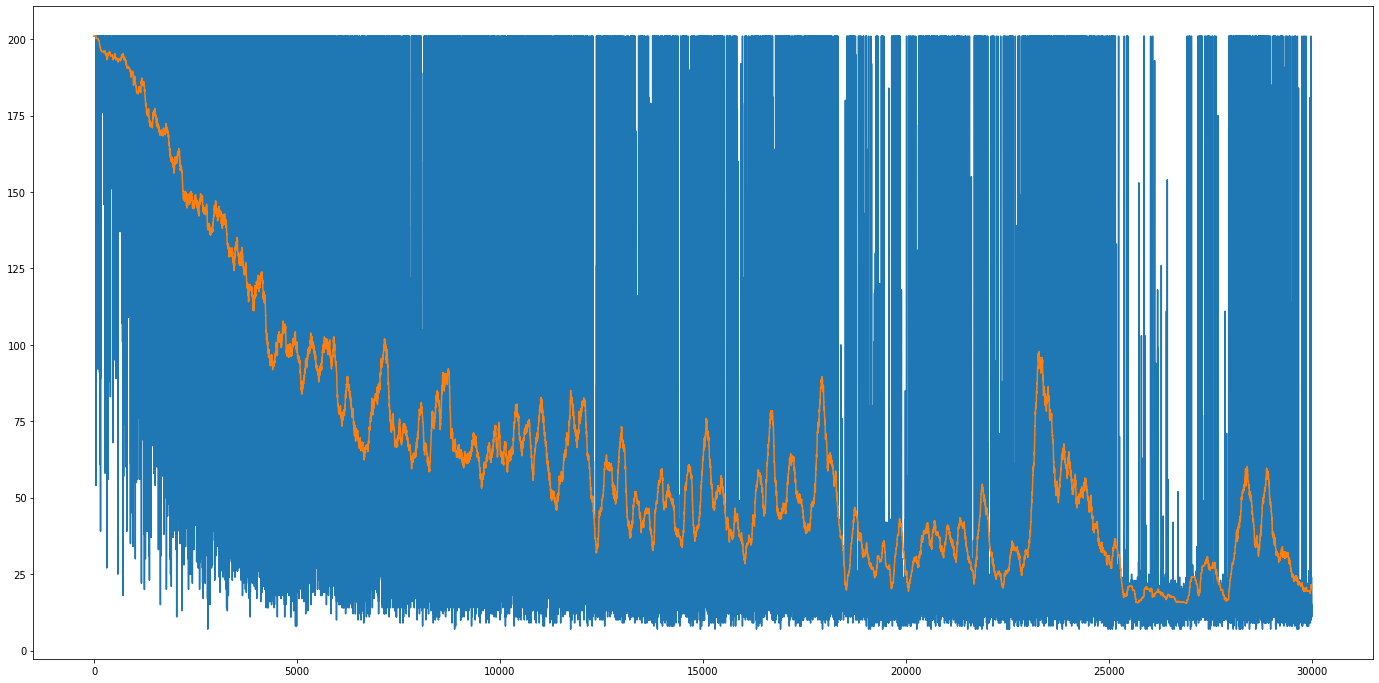

In [ ]:
#
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 12)) 
plt.plot(PathLens)
plt.plot(moving_average(PathLens, width = 200))
plt.show()

Ниже ячейку если запустить покажет одну игру по шагам.

Dn   Up   R    L    P    D

[38. 20. 38. 20. 30. 40.]

Это весовые коэффициенты для каждого действия (награды)

In [ ]:
_,_,_=PlayGame(True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
15
D    U    R    L    P    D
[36.83186 19.6     19.6     36.83186 29.204   40.     ]
